# Homework 3 (Yang Yue)

In [1]:
import glob
import json
import dask
import geopandas
import itertools
import econtools
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import multiprocess as mp
import econtools.metrics as mt
 
from functools import reduce
from math import radians, cos, sin, asin, sqrt

In [2]:
from dask.distributed import Client,progress
client = Client(threads_per_worker=2,n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:63987 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 20 Memory: 34.27 GB


## Question 1

In [3]:
dir = 'C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/Homework 3/'

In [5]:
df = dd.read_csv(dir+'BACI_HS12_Y*.csv')
glob.glob(dir+'BACI_HS12_Y*.csv')

['C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/Homework 3\\BACI_HS12_Y2012_V202001.csv',
 'C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/Homework 3\\BACI_HS12_Y2013_V202001.csv',
 'C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/Homework 3\\BACI_HS12_Y2014_V202001.csv',
 'C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/Homework 3\\BACI_HS12_Y2015_V202001.csv',
 'C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/Homework 3\\BACI_HS12_Y2016_V202001.csv',
 'C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/Homework 3\\BACI_HS12_Y2017_V202001.csv',
 'C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/Homework 3\\BACI_HS12_Y2018_V202001.csv']

## Question 2

### Part a

In [7]:
#return the number of unique importer for each exporter
df_partner12 = df.loc[df.t==2012].groupby('i')['j'].nunique().compute()

#return the country codes of the top 10 and bottom 10 exporters
df_top10 = df_partner12.sort_values(ascending=False).head(10)
df_bot10 = df_partner12.sort_values().head(10)

#construct a dictionary that maps country code to country name
df_code = pd.read_csv(dir+'country_codes_V202001.csv',encoding='ISO-8859-1')
code_dict = pd.Series(df_code.country_name_full.values,index=df_code.country_code).to_dict()

#apply the dictionary to the previous top 10 and bottom 10 frames 
df_top10 = df_top10.reset_index()
df_top10.rename(columns={'i':'Country Code','j':'Number of Partners'},inplace=True)
df_top10['Country Name'] = df_top10['Country Code'].map(code_dict)

df_bot10 = df_bot10.reset_index()
df_bot10.rename(columns={'i':'Country Code','j':'Number of Partners'},inplace=True)
df_bot10['Country Name'] = df_bot10['Country Code'].map(code_dict)

Top 10 countries with the most trading partners

In [8]:
df_top10

,Country Code,Number of Partners,Country Name
0,842,214,"USA, Puerto Rico and US Virgin Islands"
1,528,213,Netherlands
2,58,212,Belgium-Luxembourg
3,826,212,United Kingdom
4,276,212,Germany
5,410,211,Republic of Korea
6,381,210,Italy
7,757,210,"Switzerland, Liechtenstein"
8,251,209,"France, Monaco"
9,711,208,Southern African Customs Union


Bottom 10 countries with the most tranding partners

In [9]:
df_bot10

,Country Code,Number of Partners,Country Name
0,535,1,"Bonaire, Saint Eustatius and Saba"
1,534,4,Saint Maarten (Dutch part)
2,728,9,South Sudan
3,666,14,Saint Pierre and Miquelon
4,585,16,Palau
5,574,18,Norfolk Islands
6,612,19,Pitcairn
7,162,22,Christmas Islands
8,580,23,Northern Mariana Islands
9,260,23,French South Antarctic Territories


### Part b

In [10]:
#construct a dictionary that maps the 2 digit product codes to categories
category_dict ={}

for i in range(1,6):
    extend = {i:'Animal & Animal Products'}
    category_dict.update(extend)
    
for i in range(6,16):
    extend = {i:'Vegetable Products'}
    category_dict.update(extend)
    
for i in range(16,25):
    extend = {i:'Foodstuffs'}
    category_dict.update(extend)
    
for i in range(25,28):
    extend = {i:'Mineral Products'}
    category_dict.update(extend)

for i in range(28,39):
    extend = {i:'Chemical & Allied Industries'}
    category_dict.update(extend)

for i in range(39,41):
    extend = {i:'Plastics / Rubbers'}
    category_dict.update(extend)
    
for i in range(41,44):
    extend = {i:'Raw Hides, Skins, Leather, & Furs'}
    category_dict.update(extend)

for i in range(44,50):
    extend = {i:'Wood & Wood Products'}
    category_dict.update(extend)
    
for i in range(50,64):
    extend = {i:'Textiles'}
    category_dict.update(extend)

for i in range(64,68):
    extend = {i:'Footwear / Headgear'}
    category_dict.update(extend)
    
for i in range(68,72):
    extend = {i:'Stone / Glass'}
    category_dict.update(extend)
    
for i in range(72,84):
    extend = {i:'Metals'}
    category_dict.update(extend)
    
for i in range(84,86):
    extend = {i:'Machinery / Electrical'}
    category_dict.update(extend)
    
for i in range(86,90):
    extend = {i:'Transportation'}
    category_dict.update(extend)

for i in range(90,98):
    extend = {i:'Miscellaneous'}
    category_dict.update(extend)

Text(0.5, 1.0, 'Trade Volume by Category from 2012 to 2018')

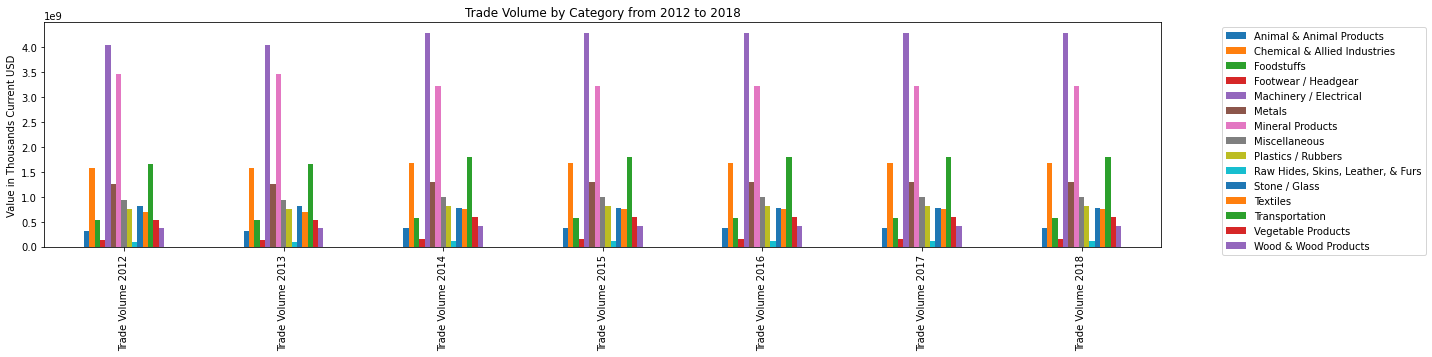

In [11]:
#create a new column with 2 digit product codes derived from the 6 digit codes
df['Category Code'] = df['k'].apply(lambda x: int(str(x)[0:2]) if len(str(x))==6 else int(str(x)[0:1]),meta=('k','int64'))

#apply the product category dictionary to the newly created column
df['Category'] = df['Category Code'].map(category_dict)

#obtain the trade volume of each category in each year
df_category_value12 = df.loc[df.t==2012].groupby('Category')['v'].sum().compute()
df_category_value13 = df.loc[df.t==2013].groupby('Category')['v'].sum().compute()
df_category_value14 = df.loc[df.t==2014].groupby('Category')['v'].sum().compute()
df_category_value15 = df.loc[df.t==2015].groupby('Category')['v'].sum().compute()
df_category_value16 = df.loc[df.t==2016].groupby('Category')['v'].sum().compute()
df_category_value17 = df.loc[df.t==2017].groupby('Category')['v'].sum().compute()
df_category_value18 = df.loc[df.t==2018].groupby('Category')['v'].sum().compute()

#create a new dataframe that joins the above frames
series_list = [df_category_value12,df_category_value13,df_category_value14,
               df_category_value15,df_category_value16,df_category_value17,
               df_category_value18]

years = [2012,2013,2014,2015,2016,2017,2018]

df_list = []

for frame,year in zip(series_list,years):
    frame = frame.to_frame()
    frame.rename(columns={'v':'Trade Volume'+' '+str(year)},inplace=True)
    df_list.append(frame)
    
df_category_value = reduce(lambda left,right: pd.merge(left,right,on='Category'),df_list)

#plot the trade volume for each category for each year
f,a = plt.subplots(figsize=(20,5))
df_category_value.T.plot(ax=a,kind='bar')
plt.ylabel('Value in Thousands Current USD')
plt.legend(bbox_to_anchor=(1.05,1.0),loc='upper left')
plt.tight_layout()

plt.title('Trade Volume by Category from 2012 to 2018')

Text(0.5, 1.0, 'Total Trade Volume by Category from 2012 to 2018')

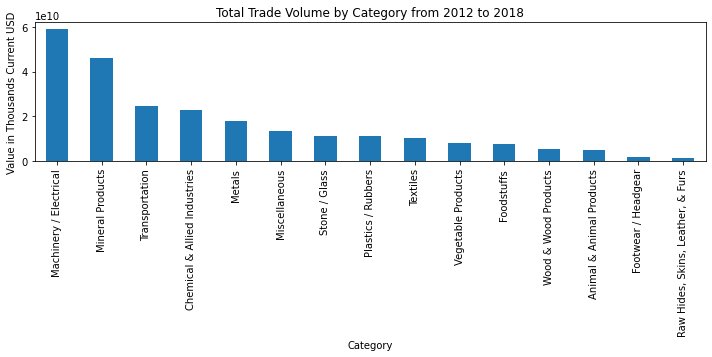

In [15]:
#calculate and plot the total trade volume for each category from 2012-2018
df_category_value_sum = df_category_value
df_category_value_sum['Total Volume'] = df_category_value_sum.sum(axis=1)
df_category_value_sum = df_category_value_sum.sort_values(by=['Total Volume'],ascending=False)

f,a = plt.subplots(figsize=(10,5))
df_category_value_sum['Total Volume'].T.plot(ax=a,kind='bar')
plt.ylabel('Value in Thousands Current USD')
plt.tight_layout()

plt.title('Total Trade Volume by Category from 2012 to 2018')

## Question 3

### Part a

In [26]:
#construct a dictionary that maps product codes to description
df_pcode = pd.read_csv(dir+'product_codes_HS12_V202001.csv')
pcode_dict = pd.Series(df_pcode.description.values,index=df_pcode.code).to_dict()

#apply the dictionary to the brazilian data and get the top 10 products
df_brazil = df.loc[df.i==76].compute()
df_brazil_12 = df_brazil.loc[df_brazil.t==2012]
"""same product multiples importers"""
df_brazil_12 = df_brazil_12.groupby('k')['v'].sum()
df_brazil_12 = df_brazil_12.to_frame()
df_brazil_12 = df_brazil_12.sort_values(by=['v'],ascending=False)
df_brazil_12 = df_brazil_12.reset_index()
df_brazil_12['Product Description'] = df_brazil_12['k'].map(pcode_dict)
df_brazil_12.head(10)

,k,v,Product Description
0,260111,2.497592e+07,Iron ores and concentrates: non-agglomerated
1,270900,2.086092e+07,Oils: petroleum oils and oils obtained from bi...
2,120190,1.741984e+07,"Soya beans: other than seed, whether or not br..."
3,170114,9.870907e+06,"Sugars: cane sugar, raw, in solid form, other ..."
4,260112,7.571141e+06,Iron ores and concentrates: agglomerated (excl...
5,230400,6.797181e+06,Oil-cake and other solid residues: whether or ...
6,90111,6.025826e+06,Coffee: not roasted or decaffeinated
7,271000,5.525909e+06,Petroleum oils and oils from bituminous minera...
8,100590,5.187145e+06,"Cereals: maize (corn), other than seed"
9,470329,4.651875e+06,"Wood pulp: chemical wood pulp, soda or sulphat..."


### Part b

In [54]:
#top 10 goods in terms of value
df_brazil_v = df_brazil.groupby('k')['v'].sum()
df_brazil_v = pd.DataFrame(df_brazil_v)
df_brazil_v.rename(columns={'v':'Total Value'},inplace=True)
df_brazil_v.reset_index(inplace=True)
df_brazil_v['Product Description'] = df_brazil_v['k'].map(pcode_dict)
df_brazil_v.sort_values(by=['Total Value'],ascending=False).head(10)

,k,Total Value,Product Description
498,120190,1.634124e+08,"Soya beans: other than seed, whether or not br..."
869,260111,1.311914e+08,Iron ores and concentrates: non-agglomerated
918,270900,1.156269e+08,Oils: petroleum oils and oils obtained from bi...
638,170114,5.542528e+07,"Sugars: cane sugar, raw, in solid form, other ..."
781,230400,4.432771e+07,Oil-cake and other solid residues: whether or ...
2035,470329,4.089617e+07,"Wood pulp: chemical wood pulp, soda or sulphat..."
409,90111,3.693469e+07,Coffee: not roasted or decaffeinated
457,100590,3.295571e+07,"Cereals: maize (corn), other than seed"
870,260112,3.287332e+07,Iron ores and concentrates: agglomerated (excl...
62,20714,3.004127e+07,Meat and edible offal: of fowls of the species...


In [56]:
#top 10 goods in terms of quantity
df_brazil_q = df_brazil.groupby('k')['q'].sum()
df_brazil_q = pd.DataFrame(df_brazil_q)
df_brazil_q.rename(columns={'q':'Total Quantity'},inplace=True)
df_brazil_q.reset_index(inplace=True)
df_brazil_q['Product Description'] = df_brazil_q['k'].map(pcode_dict)
df_brazil_q.sort_values(by=['Total Quantity'],ascending=False).head(10)

,k,Total Quantity,Product Description
869,260111,2.226085e+09,Iron ores and concentrates: non-agglomerated
498,120190,3.787319e+08,"Soya beans: other than seed, whether or not br..."
870,260112,2.968552e+08,Iron ores and concentrates: agglomerated (excl...
918,270900,2.664365e+08,Oils: petroleum oils and oils obtained from bi...
457,100590,1.706721e+08,"Cereals: maize (corn), other than seed"
638,170114,1.464199e+08,"Sugars: cane sugar, raw, in solid form, other ..."
781,230400,1.054343e+08,Oil-cake and other solid residues: whether or ...
2035,470329,8.372035e+07,"Wood pulp: chemical wood pulp, soda or sulphat..."
876,260600,5.787557e+07,Aluminium ores and concentrates
980,281820,5.529607e+07,Aluminium oxide: other than artificial corundum


## Question 4

### Part a

<AxesSubplot:>

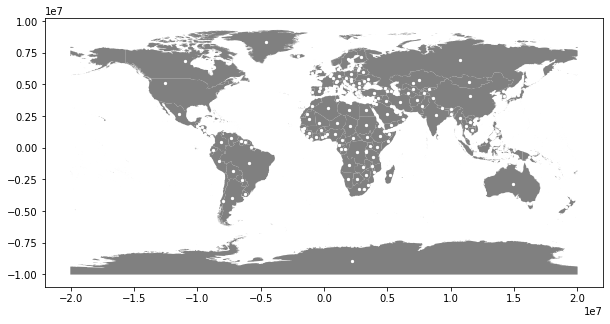

In [57]:
#read the data and change crs
countries = geopandas.read_file(dir+'countries.geojson')
countries_proj = countries.to_crs(epsg=4087)

#plot the countries with centroid
f,a = plt.subplots(figsize=(10,10))
countries_proj.plot(ax=a,zorder=1,color='gray')
countries_proj.centroid.plot(ax=a,color='white',markersize=5)

In [58]:
#find the position of brazil in the projection dataframe
brazil_index = countries_proj.index[countries_proj['ADMIN']=='Brazil'].tolist()

#establish the centroid of brazil
brazil_cent = countries_proj.centroid[brazil_index[0]]

#calculate the distance between brazil and other countries in km using the distance function
countries_proj['brazil_dist'] = countries_proj.centroid.distance(brazil_cent)/1000
countries_proj

,ADMIN,ISO_A3,geometry,brazil_dist
0,Aruba,ABW,"POLYGON ((-7792023.454 1400130.035, -7785283.4...",3202.790838
1,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032
2,Angola,AGO,"MULTIPOLYGON (((1306614.688 -1858209.281, 1306...",7864.236441
3,Anguilla,AIA,"MULTIPOLYGON (((-7017321.150 2027457.219, -702...",3414.266868
4,Albania,ALB,"POLYGON ((2198311.227 4739861.562, 2198115.639...",9985.559834
...,...,...,...,...
250,Samoa,WSM,"MULTIPOLYGON (((-19099086.934 -1551589.427, -1...",13258.807650
251,Yemen,YEM,"MULTIPOLYGON (((5934246.071 1349013.509, 59344...",11595.003670
252,South Africa,ZAF,"MULTIPOLYGON (((4214976.725 -5225431.577, 4211...",8936.163482
253,Zambia,ZMB,"POLYGON ((3464244.349 -959198.926, 3466602.913...",9006.978733


### Part b

In [64]:
#construct a dictionary that maps the country codes to 3 digit ISO values
code_dict_3digit = pd.Series(df_code.iso_3digit_alpha.values,index=df_code.country_code).to_dict()

#apply the dictionary to the dataframe to get a ISO_A3 column
df_brazil_q4 = df_brazil
df_brazil_q4['ISO_A3'] = df_brazil_q4['j'].map(code_dict_3digit)

#group by country and get the total export value to each country
df_brazil_q4_by_vimporter = df_brazil_q4.groupby('ISO_A3')['v'].sum()
df_brazil_q4_by_vimporter = df_brazil_q4_by_vimporter.to_frame()
df_brazil_q4_by_vimporter = df_brazil_q4_by_vimporter.reset_index()
df_brazil_q4_by_vimporter = df_brazil_q4_by_vimporter.rename(columns={'v':'Total Value'})
df_brazil_q4_by_vimporter = df_brazil_q4_by_vimporter.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
df_brazil_q4_by_vimporter['Log Distance'] = np.log2(df_brazil_q4_by_vimporter['brazil_dist'])
df_brazil_q4_by_vimporter['Log Total Value'] = np.log2(df_brazil_q4_by_vimporter['Total Value'])

##group by country and get the total export quantity to each country
df_brazil_q4_by_qimporter = df_brazil_q4.groupby('ISO_A3')['q'].sum()
df_brazil_q4_by_qimporter = df_brazil_q4_by_qimporter.to_frame()
df_brazil_q4_by_qimporter = df_brazil_q4_by_qimporter.reset_index()
df_brazil_q4_by_qimporter = df_brazil_q4_by_qimporter.rename(columns={'q':'Total Quantity'})
df_brazil_q4_by_qimporter = df_brazil_q4_by_qimporter.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
df_brazil_q4_by_qimporter['Log Distance'] = np.log2(df_brazil_q4_by_qimporter['brazil_dist'])
df_brazil_q4_by_qimporter['Log Total Quantity'] = np.log2(df_brazil_q4_by_qimporter['Total Quantity'])

Text(0.5, 1.0, 'Scatter Plot Distance-Quantity')

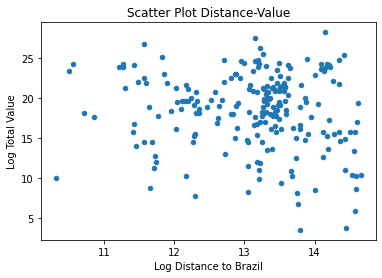

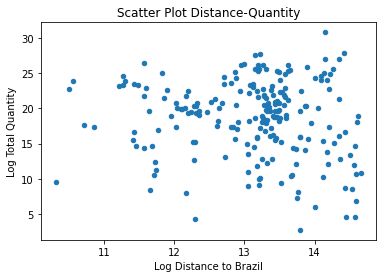

In [65]:
#scatter plot for value-distance
df_brazil_q4_by_vimporter.plot.scatter(x='Log Distance',y='Log Total Value')
plt.xlabel('Log Distance to Brazil')
plt.title('Scatter Plot Distance-Value')

#scatter plot for quantity-distance
df_brazil_q4_by_qimporter.plot.scatter(x='Log Distance',y='Log Total Quantity')
plt.xlabel('Log Distance to Brazil')
plt.title('Scatter Plot Distance-Quantity')

### Part c

In [66]:
#correlation between value and distance
correlation_vd = df_brazil_q4_by_vimporter['Total Value'].corr(df_brazil_q4_by_vimporter['brazil_dist'])

#correlation between quantity and distance
correlation_qd = df_brazil_q4_by_qimporter['Total Quantity'].corr(df_brazil_q4_by_qimporter['brazil_dist'])

print('corr value-distance: '+str(correlation_vd))
print('corr quantity-distance: '+str(correlation_qd))

corr value-distance: 0.04153861031023011
corr quantity-distance: 0.11313878803184693


Weak correlation for both value and quantity. This is not surprising since contemporary trade isn't severly restricted by geographical distance. 

### Part d

In [70]:
df_brazil_q4_ext = df_brazil_q4

In [71]:
#animal & animal products
df_brazil_q4_ext_ani = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Animal & Animal Products']
df_brazil_q4_ext_ani = df_brazil_q4_ext_ani.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_ani = df_brazil_q4_ext_ani.to_frame()
df_brazil_q4_ext_ani = df_brazil_q4_ext_ani.reset_index()
df_brazil_q4_ext_ani = df_brazil_q4_ext_ani.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_animal_dist = df_brazil_q4_ext_ani['q'].corr(df_brazil_q4_ext_ani['brazil_dist'])

#vegetable products
df_brazil_q4_ext_veg = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Vegetable Products']
df_brazil_q4_ext_veg = df_brazil_q4_ext_veg.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_veg = df_brazil_q4_ext_veg.to_frame()
df_brazil_q4_ext_veg = df_brazil_q4_ext_veg.reset_index()
df_brazil_q4_ext_veg = df_brazil_q4_ext_veg.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_veg_dist = df_brazil_q4_ext_veg['q'].corr(df_brazil_q4_ext_veg['brazil_dist'])

#foodstuffs
df_brazil_q4_ext_food = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Foodstuffs']
df_brazil_q4_ext_food = df_brazil_q4_ext_food.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_food = df_brazil_q4_ext_food.to_frame()
df_brazil_q4_ext_food = df_brazil_q4_ext_food.reset_index()
df_brazil_q4_ext_food = df_brazil_q4_ext_food.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_food_dist = df_brazil_q4_ext_food['q'].corr(df_brazil_q4_ext_food['brazil_dist'])

#chemicals $ allied industries
df_brazil_q4_ext_chem = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Chemical & Allied Industries']
df_brazil_q4_ext_chem = df_brazil_q4_ext_chem.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_chem = df_brazil_q4_ext_chem.to_frame()
df_brazil_q4_ext_chem = df_brazil_q4_ext_chem.reset_index()
df_brazil_q4_ext_chem = df_brazil_q4_ext_chem.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_chem_dist = df_brazil_q4_ext_chem['q'].corr(df_brazil_q4_ext_chem['brazil_dist'])

#plastics / rubbers
df_brazil_q4_ext_plas = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Plastics / Rubbers']
df_brazil_q4_ext_plas = df_brazil_q4_ext_plas.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_plas = df_brazil_q4_ext_plas.to_frame()
df_brazil_q4_ext_plas = df_brazil_q4_ext_plas.reset_index()
df_brazil_q4_ext_plas = df_brazil_q4_ext_plas.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_plas_dist = df_brazil_q4_ext_plas['q'].corr(df_brazil_q4_ext_plas['brazil_dist'])

#raw hides, skins, leather, & furs
df_brazil_q4_ext_fur = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Raw Hides, Skins, Leather, & Furs']
df_brazil_q4_ext_fur = df_brazil_q4_ext_fur.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_fur = df_brazil_q4_ext_fur.to_frame()
df_brazil_q4_ext_fur = df_brazil_q4_ext_fur.reset_index()
df_brazil_q4_ext_fur = df_brazil_q4_ext_fur.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_fur_dist = df_brazil_q4_ext_fur['q'].corr(df_brazil_q4_ext_fur['brazil_dist'])

#mineral products
df_brazil_q4_ext_mine = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Mineral Products']
df_brazil_q4_ext_mine = df_brazil_q4_ext_mine.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_mine = df_brazil_q4_ext_mine.to_frame()
df_brazil_q4_ext_mine = df_brazil_q4_ext_mine.reset_index()
df_brazil_q4_ext_mine = df_brazil_q4_ext_mine.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_mine_dist = df_brazil_q4_ext_mine['q'].corr(df_brazil_q4_ext_mine['brazil_dist'])

#wood & wood products
df_brazil_q4_ext_wood = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Wood & Wood Products']
df_brazil_q4_ext_wood = df_brazil_q4_ext_wood.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_wood = df_brazil_q4_ext_wood.to_frame()
df_brazil_q4_ext_wood = df_brazil_q4_ext_wood.reset_index()
df_brazil_q4_ext_wood = df_brazil_q4_ext_wood.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_wood_dist = df_brazil_q4_ext_wood['q'].corr(df_brazil_q4_ext_wood['brazil_dist'])

#textiles
df_brazil_q4_ext_tex = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Textiles']
df_brazil_q4_ext_tex = df_brazil_q4_ext_tex.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_tex = df_brazil_q4_ext_tex.to_frame()
df_brazil_q4_ext_tex = df_brazil_q4_ext_tex.reset_index()
df_brazil_q4_ext_tex = df_brazil_q4_ext_tex.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_tex_dist = df_brazil_q4_ext_tex['q'].corr(df_brazil_q4_ext_tex['brazil_dist'])

#footwear / headgear
df_brazil_q4_ext_foot = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Footwear / Headgear']
df_brazil_q4_ext_foot = df_brazil_q4_ext_foot.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_foot = df_brazil_q4_ext_foot.to_frame()
df_brazil_q4_ext_foot = df_brazil_q4_ext_foot.reset_index()
df_brazil_q4_ext_foot = df_brazil_q4_ext_foot.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_foot_dist = df_brazil_q4_ext_foot['q'].corr(df_brazil_q4_ext_foot['brazil_dist'])

#stone / glass
df_brazil_q4_ext_stone = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Stone / Glass']
df_brazil_q4_ext_stone = df_brazil_q4_ext_stone.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_stone = df_brazil_q4_ext_stone.to_frame()
df_brazil_q4_ext_stone = df_brazil_q4_ext_stone.reset_index()
df_brazil_q4_ext_stone = df_brazil_q4_ext_stone.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_stone_dist = df_brazil_q4_ext_stone['q'].corr(df_brazil_q4_ext_stone['brazil_dist'])

#metals
df_brazil_q4_ext_met = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Metals']
df_brazil_q4_ext_met = df_brazil_q4_ext_met.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_met = df_brazil_q4_ext_met.to_frame()
df_brazil_q4_ext_met = df_brazil_q4_ext_met.reset_index()
df_brazil_q4_ext_met = df_brazil_q4_ext_met.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_met_dist = df_brazil_q4_ext_met['q'].corr(df_brazil_q4_ext_met['brazil_dist'])

#machinery / electrical
df_brazil_q4_ext_mech = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Machinery / Electrical']
df_brazil_q4_ext_mech = df_brazil_q4_ext_mech.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_mech = df_brazil_q4_ext_mech.to_frame()
df_brazil_q4_ext_mech = df_brazil_q4_ext_mech.reset_index()
df_brazil_q4_ext_mech = df_brazil_q4_ext_mech.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_mech_dist = df_brazil_q4_ext_mech['q'].corr(df_brazil_q4_ext_mech['brazil_dist'])

#transportation
df_brazil_q4_ext_trans = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Transportation']
df_brazil_q4_ext_trans = df_brazil_q4_ext_trans.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_trans = df_brazil_q4_ext_trans.to_frame()
df_brazil_q4_ext_trans = df_brazil_q4_ext_trans.reset_index()
df_brazil_q4_ext_trans = df_brazil_q4_ext_trans.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_trans_dist = df_brazil_q4_ext_trans['q'].corr(df_brazil_q4_ext_trans['brazil_dist'])

#miscellaneous
df_brazil_q4_ext_misc = df_brazil_q4_ext.loc[df_brazil_q4_ext.Category=='Miscellaneous']
df_brazil_q4_ext_misc = df_brazil_q4_ext_misc.groupby('ISO_A3')['q'].sum()
df_brazil_q4_ext_misc = df_brazil_q4_ext_misc.to_frame()
df_brazil_q4_ext_misc = df_brazil_q4_ext_misc.reset_index()
df_brazil_q4_ext_misc = df_brazil_q4_ext_misc.merge(countries_proj,left_on='ISO_A3',right_on='ISO_A3')
corr_misc_dist = df_brazil_q4_ext_misc['q'].corr(df_brazil_q4_ext_misc['brazil_dist'])

In [72]:
#complie and summarize the correlation statistics
corr_data = [corr_animal_dist,corr_veg_dist,corr_food_dist,corr_mine_dist,
             corr_chem_dist,corr_plas_dist,corr_fur_dist,corr_wood_dist,
             corr_tex_dist,corr_foot_dist,corr_stone_dist,corr_met_dist,
             corr_mech_dist,corr_trans_dist,corr_misc_dist]
index = ['Animal & Animal Products','Vegetable Products','Foodstuffs','Mineral Products',
         'Chemical & Allied Industries','Plastics / Rubbers','Raw Hides, Skins, Leather, & Furs','Wood & Wood Products',
         'Textiles','Footwear / Headgear','Stone / Glass','Metals',
         'Machinery / Electrical','Transportation','Miscellaneous']
corr_cat_dist = pd.Series(corr_data,index=index)
corr_cat_dist.sort_values(ascending=False)

Textiles                             0.223634
Animal & Animal Products             0.162544
Mineral Products                     0.149120
Vegetable Products                   0.135592
Raw Hides, Skins, Leather, & Furs    0.131216
Foodstuffs                           0.118982
Wood & Wood Products                 0.087006
Metals                              -0.028301
Chemical & Allied Industries        -0.033171
Stone / Glass                       -0.105325
Transportation                      -0.128017
Machinery / Electrical              -0.132009
Plastics / Rubbers                  -0.165190
Footwear / Headgear                 -0.176872
Miscellaneous                       -0.235153
dtype: float64

Miscellaneous category has the strongest negative correlation with distance. Textiles category has the strongest positive correlation with distance. Once again, one should treat this result with suspicion since trade isn't severely restricted by distance these days.

## Question 5

### Part a

In [76]:
#sse_1p function that returns the sum of squared errors
def SSE_1p(beta,q,d):
    sse_1p = 0
    for q_j,d_j in zip(q,d):
        e = np.log2(q_j)-beta*np.log2(d_j)
        sse_1p = sse_1p+e**2
    return sse_1p

### Part b

In [77]:
#search function that returns the beta that minimizes sse
def search_1p(beta_range):
    errors = []
    for i in range(0,beta_grid,1):
        errors.append(SSE_1p(beta_range[i],q,d))
    beta_choice = beta_range[np.argmin(errors)]    
    return beta_choice,errors

In [78]:
#parameters range and value
beta_min = -1
beta_max = 3.005
beta_range = np.arange(beta_min,beta_max,0.005)
beta_grid = len(beta_range)
q = df_brazil_q4_by_qimporter['Total Quantity'].tolist()
d = df_brazil_q4_by_qimporter['brazil_dist'].tolist()

#get beta hat
beta_hat = search_1p(beta_range)[0]
print('The beta value that minimizes the SSE is: '+str(beta_hat))

The beta value that minimizes the SSE is: 1.410000000000002


Once again, distance is no longer the primary restricting factor for trade these days. One should take this result with a grain of salt.

Text(0, 0.5, 'Sum of Square Errors')

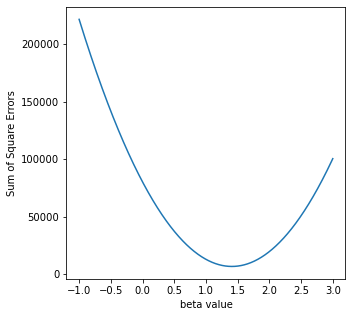

In [79]:
#plot the beta candidates and corresponding sse
f,a = plt.subplots(figsize=(5,5))
xAxis = beta_range
a.plot(xAxis,search_1p(beta_range)[1])
plt.xlabel('beta value')
plt.ylabel('Sum of Square Errors')

### Part c

In [80]:
##sse_2p function that returns the sum of squared errors
def SSE_2p(vbeta,q,d): 
    sse_2p = 0
    vbeta0,vbeta1 = vbeta
    for q_j,d_j in zip(q,d):
        e = np.log2(q_j)-vbeta0-vbeta1*np.log2(d_j)
        sse_2p = sse_2p+e**2
    return sse_2p

### Part d

In [82]:
#search function that returns the beta that minimizes sse
def serach_2p(beta0_range,beta1_range):
    errors = []
    for vbeta in itertools.product(beta0_range,beta1_range):
        errors.append(SSE_2p(vbeta,q,d))
    vbeta_choice = list(itertools.product(beta0_range,beta1_range))[np.argmin(errors)]
    return vbeta_choice,errors

In [86]:
#parameters range and value
beta0_min = 1500
beta0_max = 2510
beta0_range = np.arange(beta0_min,beta0_max,10)
beta0_grid = len(beta0_range)
beta1_min = -1
beta1_max = 3.005
beta1_range = np.arange(beta1_min,beta1_max,0.005)
beta1_grid = len(beta1_range)
q = df_brazil_q4_by_qimporter['Total Quantity'].tolist()
d = df_brazil_q4_by_qimporter['brazil_dist'].tolist()

#get beta hat vector
vbeta_hat = serach_2p(beta0_range,beta1_range)[0]
print('The beta values that minimize the SSE are: '+str(vbeta_hat))

The beta values that minimize the SSE are: (1500, -1.0)


The given range for beta0 is too far off from the true value. 

### Part e

In [87]:
#ols regression 
df_brazil_q5_by_qimporter = df_brazil_q4_by_qimporter
df_brazil_q5_by_qimporter['Ones'] = 1
result = mt.reg(df_brazil_q5_by_qimporter,'Log Total Quantity',['Ones','Log Distance'])
result

Dependent variable:	Log Total Quantity
N:			214
R-squared:		0.0112
Estimation method:	OLS
VCE method:		Standard (Homosk.)
              coeff    se      t   p>t CI_low CI_high
Ones         26.749 5.266  5.079 0.000 16.368  37.129
Log Distance -0.621 0.401 -1.550 0.123 -1.410   0.169

Note that if we change the range of the first parameter from (1500,2500) to (0,50) with steps of 1 for example, then the result from grid search is close to the one of running OLS.

### Part f

In [91]:
#prepare the data
df_gdp = pd.read_csv(dir+'GDP.csv')
df_gdp = df_gdp.rename(columns={'Country Code':'ISO_A3'})

df_gdp['2012 [YR2012]'] = pd.to_numeric(df_gdp['2012 [YR2012]'],errors='coerce')
df_gdp['2013 [YR2013]'] = pd.to_numeric(df_gdp['2013 [YR2013]'],errors='coerce')
df_gdp['2014 [YR2014]'] = pd.to_numeric(df_gdp['2014 [YR2014]'],errors='coerce')
df_gdp['2015 [YR2015]'] = pd.to_numeric(df_gdp['2015 [YR2015]'],errors='coerce')
df_gdp['2016 [YR2016]'] = pd.to_numeric(df_gdp['2016 [YR2016]'],errors='coerce')
df_gdp['2017 [YR2017]'] = pd.to_numeric(df_gdp['2017 [YR2017]'],errors='coerce')
df_gdp['2018 [YR2018]'] = pd.to_numeric(df_gdp['2018 [YR2018]'],errors='coerce')

df_gdp['GDP Sum'] = df_gdp.iloc[:,-9:-2].sum(axis=1)
df_gdp = df_gdp[['ISO_A3','GDP Sum']]

#add the gdp data to the brazilian dataframe
df_brazil_q5_by_qimporter = df_brazil_q5_by_qimporter.merge(df_gdp,left_on='ISO_A3',right_on='ISO_A3')
df_brazil_q5_by_qimporter['Log GDP'] = np.log2(df_brazil_q5_by_qimporter['GDP Sum'].replace(0,np.nan))

#run the ols regression
result_gdp = mt.reg(df_brazil_q5_by_qimporter,'Log Total Quantity',['Ones','Log Distance','Log GDP'])
result_gdp

Dependent variable:	Log Total Quantity
N:			192
R-squared:		0.7103
Estimation method:	OLS
VCE method:		Standard (Homosk.)
              coeff    se      t   p>t  CI_low CI_high
Ones         -6.527 3.212 -2.032 0.044 -12.863  -0.190
Log Distance -1.369 0.210 -6.522 0.000  -1.783  -0.955
Log GDP       1.165 0.055 21.220 0.000   1.057   1.274

With GDP in the regression, the parameter for distance changes to negative. This matches the intuition that distance should negatively affect trade quantity between countries.

## Question 6

The intuition is that perishable goods like foodstuffs and vegatable products are most sensitive to distance. It would be great to have data on the primary mode of transportation as well as how long it takes to travel for each 6-digit product between 2 countries. Also, perhaps one could incorporte data on how long it takes for a product to expire. I would join the datasets together on the 6-digit product code and run regression on quantity-distance for those goods that are easily perished and require long travel time. I suspect the result will show a strong negative correlation between quantity and distance for those goods.